In [1]:
! pip install --upgrade -q pandas numpy scikit-learn imbalanced-learn shap

In [2]:
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, StratifiedKFold
)
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import shap

In [3]:
RANDOM_STATE = 42

TEST_RATIO = 0.15

NUMERIC_ATTRS = ["idade_paciente", "dias_sintomas_notificacao"]

In [4]:
best_params_list = [
    {
        'n_estimators': 470, 
        'max_depth': 37, 
        'min_samples_split': 10, 
        'min_samples_leaf': 3,
        'max_features': 'sqrt',
        'random_state': RANDOM_STATE
    },
    {
        'n_estimators': 329, 
        'max_depth': 45, 
        'min_samples_split': 12, 
        'min_samples_leaf': 3, 
        'max_features': 'sqrt',
        'random_state': RANDOM_STATE
    },
    {
        'n_estimators': 100, 
        'max_depth': 43, 
        'min_samples_split': 6, 
        'min_samples_leaf': 2, 
        'max_features': 'log2',
        'random_state': RANDOM_STATE
    }
]

In [5]:
df = pd.read_csv("../data/3_gold/dataset-processed.csv")

X = df.drop("severity", axis=1)
y = df["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

In [6]:
X_opt, X_test, y_opt, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=RANDOM_STATE, stratify=y
)

X_cpu = X_opt.values
y_cpu = y_opt.values

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

mean_f1_list = []
std_f1_list = []

for best_params in best_params_list:
    scores = []
    
    for train_idx, valid_idx in skf.split(X_cpu, y_cpu):

        X_train_fold, y_train_fold = X_cpu[train_idx], y_cpu[train_idx]
        X_valid_fold, y_valid_fold = X_cpu[valid_idx], y_cpu[valid_idx]

        # --- Pre-processing (Normalization & Resampling) ---
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_valid_fold = scaler.transform(X_valid_fold)

        class_counts = Counter(y_train_fold)

        target_count = class_counts[1]

        pipeline = Pipeline([
            ('under', RandomUnderSampler(sampling_strategy={0: target_count}, random_state=RANDOM_STATE)),
            ('over', SMOTE(sampling_strategy={2: target_count}, random_state=RANDOM_STATE))
        ])

        X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_fold, y_train_fold)

        model = RandomForestClassifier(**best_params)

        model.fit(X_train_resampled, y_train_resampled)

        preds = model.predict(X_valid_fold)
        f1 = f1_score(y_valid_fold, preds, average='macro')
        scores.append(f1)

    mean_f1 = np.mean(scores)
    std_f1 = np.std(scores)

    mean_f1_list.append(mean_f1)
    std_f1_list.append(std_f1)

print("Mean F1-scores:", mean_f1_list)
print("Std F1-scores:", std_f1_list)

Mean F1-scores: [np.float64(0.5508941503521625), np.float64(0.5506886814964718), np.float64(0.5535907642545881)]
Std F1-scores: [np.float64(0.002037175257356285), np.float64(0.0019497785580260367), np.float64(0.002340952928547518)]


In [8]:
best_params_final = best_params_list[np.argmax(mean_f1_list)]

print("Best hyperparameters:", best_params_final)

Best hyperparameters: {'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'random_state': 42}


In [9]:
# Train final model with best hyperparameters
scaler = StandardScaler()
X_opt_scaled = scaler.fit_transform(X_opt)
X_test_scaled = scaler.transform(X_test)

pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=RANDOM_STATE)),
    ('over', SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE))
])

X_opt_resampled, y_opt_resampled = pipeline.fit_resample(X_opt_scaled, y_opt)
final_model = RandomForestClassifier(**best_params_final)
final_model.fit(X_opt_resampled, y_opt_resampled)

# Evaluate on test set
test_preds = final_model.predict(X_test_scaled)
test_f1 = f1_score(y_test, test_preds, average='macro')
print("Test F1-score:", test_f1)

# Use f-beta score with beta=2 for more emphasis on recall
from sklearn.metrics import fbeta_score

test_f2 = fbeta_score(y_test, test_preds, beta=2, average='macro')
print("Test F2-score:", test_f2)

from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, test_preds, target_names=target_names))

Test F1-score: 0.4959565699986663
Test F2-score: 0.5213826694625344
Classification Report:
               precision    recall  f1-score   support

    low_risk       0.79      0.71      0.75     63128
       alarm       0.60      0.46      0.52     40132
      severe       0.13      0.61      0.22      4278

    accuracy                           0.61    107538
   macro avg       0.51      0.59      0.50    107538
weighted avg       0.69      0.61      0.64    107538



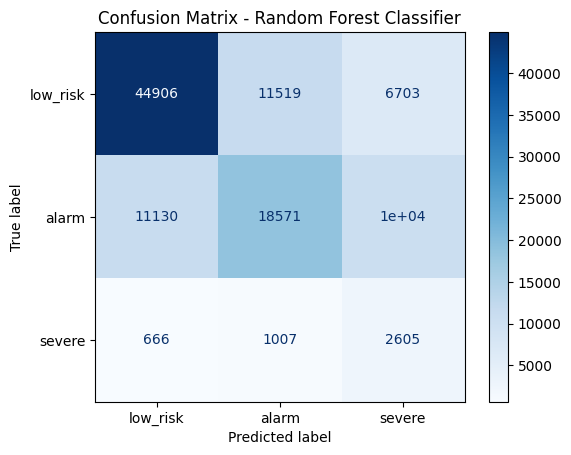

In [10]:
# Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, test_preds, display_labels=target_names, cmap=plt.cm.Blues
)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# 1. Compute SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_scaled)

# 2. Iterate through each class and plot
# target_names are ["low_risk", "alarm", "severe"]
for i, class_name in enumerate(target_names):
    print(f"Generating SHAP summary for class: {class_name}")
    
    # Handle the shape of shap_values
    # If it's a list (older versions), index it directly: shap_values[i]
    # If it's a 3D array (newer versions: samples, features, classes), slice the last dim: shap_values[:, :, i]
    if isinstance(shap_values, list):
        class_shap_values = shap_values[i]
    else:
        class_shap_values = shap_values[:, :, i]

    # 3. Generate the Summary Plot
    plt.figure()
    shap.summary_plot(
        class_shap_values, 
        X_test_scaled, 
        feature_names=feature_names,
        show=False # Prevents auto-showing so we can save/title it
    )
    
    plt.title(f"SHAP Summary: {class_name}")
    plt.tight_layout()
    # Optional: Save the figure
    # plt.savefig(f"shap_summary_{class_name}.png")
    plt.show()